# Unsupervised Learning (Clustering) - Finding Related Texts

For this exercise, we'll use use example posts from a website and find related posts based on clustering.

Essentially, we'll group similar items together and dissimilar items away from each other.

We'll also dig into text data, which is fun to work with and our vector space can grow very quickly.


### Measuring Similarity

Raw text is useless.

However, if we can transform it properly, we can do a ton of cool stuff with it, like build learning algorithms around it.

The technique we're going to use to do this is called the bag-of-word approach.  It uses simple word counts as it's basis and for each word in our row/post/etc, we count it and add it as a column in our word vector.

That's why it can grow very quickly.  The vector contains as many elements as the words that occur in the whole dataset, so we can get a huge vector pretty quickly


So our approach can be broken down to 4 steps:
    1. Turn our feature space into our vector space.  We'll have one vector per post
    2. Run those vectors through our clustering algorithm.
        a. This will be broken down into two repeatable steps later explained.
    3. We'll figure out which cluster each post belongs to.
    4. Finally we'll find other posts in the same cluster as the post in question and we'll return those as well as find a handful that are differeent from the post (to increase diversity)


### Read in Data

In [26]:
import os
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import CountVectorizer
import scipy as sp
import sys

In [2]:
[f for f in listdir('../data/')][1:]
DIR = '../data/'

In [8]:
posts = [open(os.path.join(DIR, f)).read() for f in os.listdir(DIR)]
vectorizer = CountVectorizer(min_df=1)

In [9]:
posts = posts[1:]

In [10]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("#samples: %d, #features: %d" % (num_samples, num_features)) #samples: 5, #features: 25

#samples: 5, #features: 25


In [11]:
print(vectorizer.get_feature_names())

[u'about', u'actually', u'capabilities', u'contains', u'data', u'databases', u'images', u'imaging', u'interesting', u'is', u'it', u'learning', u'machine', u'most', u'much', u'not', u'permanently', u'post', u'provide', u'safe', u'storage', u'store', u'stuff', u'this', u'toy']


Now we can vectorize our new post as follows:

In [12]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

Note that the count vectors returned by the transform method are sparse. 

That is, each vector does not store one count value for each word, as most of those counts would be zero (post does not contain the word). 

Instead, it uses the more memory efficient implementation `coo_matrix` (for "COOrdinate"). Our new post, for instance, actually contains only two elements:

In [13]:
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


But via its member `toarray()`, we can again access full `ndarray` as follows:

In [23]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


We need to use the full array if we want to use it as a vector for similarity calculations. 

For the similarity measurement (the naive one), we calculate the Euclidean distance between the count vectors of the new post and all the old posts as follows:

In [25]:
def dist_raw(v1, v2):
    delta = v1-v2
    return sp.linalg.norm(delta.toarray())

The `norm()` function calculates the Euclidean norm (shortest distance). With `dist_raw`, we just need to iterate over all the posts and remember the nearest one

In [29]:
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_raw(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=4.00: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=1.73: Imaging databases provide storage capabilities.
=== Post 2 with dist=2.00: Most imaging databases safe images permanently.
=== Post 3 with dist=1.41: Imaging databases store data.
=== Post 4 with dist=5.10: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=1.41


We have our first similarity measurement. 

Post 0 is most dissimilar from our new post, which makes a ton of sense since it does not have a single word in common with the new post.

We can also understand that Post 1 is very similar to the new post, but not to the winner, as it contains one word more than Post 3 that is not contained in the new post.

Looking at posts 3 and 4, however, the picture is not so clear any more. Post 4 is the same as Post 3, duplicated three times. So, it should also be of the same similarity to the new post as Post 3.

Obviously, using only the counts of the raw words is too simple. We will have to normalize them to get vectors of unit length.

### Let's normalize

In [30]:
def dist_norm(v1, v2):
    v1_normalized = v1/sp.linalg.norm(v1.toarray())
    v2_normalized = v2/sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized
    return sp.linalg.norm(delta.toarray())


In [31]:
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.92: Most imaging databases safe images permanently.
=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=0.77


This looks a bit better now. Post 3 and Post 4 are calculated as being equally similar. One could argue whether that much repetition would be a delight to the reader, but from the point of counting the words in the posts, it's not wrong.

### Building on our Vectorizer - Stopwords

Of its words that are not in the new post, we have "most", "safe", "images", and "permanently". 

They are actually quite different in the overall importance to the post. 

Words such as "most" appear very often in all sorts of different contexts, and words such as this are called stop words. They do not carry as much information, and thus should not be weighed as much as words such as "images", that don't occur often in different contexts. 

The best option is usually to remove all words that are so frequent that they do not help to distinguish between different texts. These words are called stop words.  Lucky for us, stopwords are built into most nlp toolkits so we don't have to build it ourselves.  Although, at times, it may be necessary.

For instance, while analyzing presidential debates in 2016, there were specific contextual stopwords that I had to account for.



In [32]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')

In [33]:
sorted(vectorizer.get_stop_words())[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

let's try our distance measurements again

In [36]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape

In [37]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

In [38]:
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_raw(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=3.16: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=1.73: Imaging databases provide storage capabilities.
=== Post 2 with dist=1.73: Most imaging databases safe images permanently.
=== Post 3 with dist=1.41: Imaging databases store data.
=== Post 4 with dist=5.10: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=1.41


In [39]:
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.86: Most imaging databases safe images permanently.
=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=0.77


### Another thing we can do to these words is to stem them.

Stemming is a technique used to combine words of different tenses / variants as one.  It's a little odd when you first look at it because inherent in the technique is the possibility of stemming or cutting off the ending of words. So they might not look like valid english words afterwards. But don't freak out

In [41]:
import nltk

In [45]:
s= nltk.stem.SnowballStemmer('english')
print s.stem("computers")
print s.stem("matriculating")
print s.stem("matriculate")
print s.stem("matriculation")

comput
matricul
matricul
matricul


So let's do what we came to do, extend the vectorizer with NLTK's stemmer.

We need to stem the posts before we feed them into CountVectorizer. 

The class provides several hooks with which we could customize the preprocessing and tokenization stages. 

The preprocessor and tokenizer can be set in the constructor as parameters. 

We do not want to place the stemmer into any of them, because we would then have to do the tokenization and normalization by ourselves. Instead, we overwrite the method build_analyzer as follows:

In [46]:
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))


In [47]:
vectorizer = StemmedCountVectorizer(min_df=1, stop_words='english')

This will perform the following steps for each post:

1. Lower casing the raw post in the preprocessing step (done in the parent class).

2. Extracting all individual words in the tokenization step (done in the parent class).

3. Converting each word into its stemmed version.


As a result, we now have one feature less, because "images" and "imaging" collapsed to one. 


In [48]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape

In [49]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

In [50]:
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.63: Most imaging databases safe images permanently.
=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 2 with dist=0.63


Looks like that changed up the standings this time.  If you notice, post 2 is now the most similar as it contains 'imag' twice

### TF-IDF 

Now that we have a reasonable way to extract a compact vector from a noisy textual post, let's step back for a while to think about what the feature values actually mean.

**The feature values simply count occurrences of terms in a post.** We silently assumed that higher values for a term also mean that the term is of greater importance to the given post. 

But what about, for instance, the word "subject", which naturally occurs in each and every single post? 

We could tell CountVectorizer to remove it as well by means of its `max_df` parameter. We could, for instance, set it to 0.9 so that all words that occur in more than 90 percent of all posts would be always ignored. 

But what about words that appear in 89 percent of all posts? 

How low would we be willing to set max_df? **The problem is that however we set it, there will always be some terms that are just more discriminative than others.**

This can only be solved by counting term frequencies for every post, and in addition, discounting those that appear in many posts. **In other words, we want a high value for a given term in a given value if that term occurs often in that particular post and very rarely anywhere else.**

This is exactly what term frequency – inverse document frequency (TF-IDF) does; TF stands for the counting part, while IDF factors in the discounting. A naive implementation would look like the following:



In [56]:
import scipy as sp
def tfidf(term, doc, docset):
    tf = float(doc.count(term))*1.0/sum(doc.count(w) for w in docset)
    idf = math.log(float(len(docset))/(len([doc for doc in docset if term in doc])))
    return tf * idf

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,
                             self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [60]:
vectorizer = StemmedTfidfVectorizer(min_df=1,stop_words='english')

In [62]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])
best_doc = None
best_dist = sys.maxint
best_i = None
for i in range(0, num_samples):
    post = posts[i]
    if post==new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print "=== Post %i with dist=%.2f: %s"%(i, d, post)
    if d<best_dist:
        best_dist = d
        best_i = i
        
print("Best post is %i with dist=%.2f"%(best_i, best_dist))

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=1.08: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.86: Most imaging databases safe images permanently.
=== Post 3 with dist=0.92: Imaging databases store data.
=== Post 4 with dist=0.92: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 2 with dist=0.86


### Where we're at

Our current text preprocessing phase includes the following steps:

1. Tokenizing the text.
2. Throwing away words that occur way too often to be of any help in detecting relevant posts.
3. Throwing away words that occur so seldom that there is only a small chance that they occur in future posts.
4. Counting the remaining words.
5. Calculating TF-IDF values from the counts, considering the whole text corpus.


But, as simple and as powerful as the bag-of-words approach with its extensions is, it has some drawbacks that we should be aware of. 

They are as follows:
1. It does not cover word relations. With the previous vectorization approach, the text "Car hits wall" and "Wall hits car" will both have the same feature vector.
2. It does not capture negations correctly. 
    a. For instance, the text "I will eat ice cream" and "I will not eat ice cream" will look very similar by means of their feature vectors, although they contain quite the opposite meaning. 
    b. This problem, however, can be easily changed by not only counting individual words, also called unigrams, but also considering bigrams (pairs of words) or trigrams (three words in a row).
3. It totally fails with misspelled words. Although it is clear to the readers that "database" and "databas" convey the same meaning, our approach will treat them as totally different words.


### Now that we have our feature vectors that appropriately reflect our posts, let's cluster them!

Most clustering algorithms fall into one of the two methods, flat and hierarchical clustering.

**Flat clustering** divides the posts into a set of clusters without relating the clusters to each other. The goal is simply to come up with a partitioning such that all posts in one cluster are most similar to each other while being dissimilar from the posts in all other clusters. **Many flat clustering algorithms require the number of clusters to be specified up front.** (Think K-Means)

In **hierarchical clustering**, the number of clusters does not have to be specified. Instead, the hierarchical clustering creates a hierarchy of clusters. While similar posts are grouped into one cluster, similar clusters are again grouped into one uber-cluster. This is done recursively, until only one cluster is left, which contains everything. In this hierarchy, one can then choose the desired number of clusters. However, this comes at the cost of lower efficiency.

Scikit provides a wide range of clustering approaches in the package sklearn.cluster. You can get a quick overview of the advantages and drawbacks of each of them at http://scikit-learn.org/dev/modules/clustering.html.


### K-Means

KMeans is the most widely used flat clustering algorithm. 

It works in two steps

1. Randomly initiates cluster centroids and assigns each training example to it's closest centroid.
2. For each cluster, the centroid is moved to the mean and each training example is then (potentially) reassigned to it's closest centroid.

Rinse and repeat until there is no more movement



In [64]:
import os
import scipy as sp
from scipy.stats import norm
from matplotlib import pylab
from sklearn.cluster import KMeans
%matplotlib inline

seed = 2
sp.random.seed(seed)  # to reproduce the data later on

num_clusters = 3


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    pylab.figure(num=None, figsize=(8, 6))
    if km:
        pylab.scatter(x, y, s=50, c=km.predict(list(zip(x, y))))
    else:
        pylab.scatter(x, y, s=50)

    pylab.title(title)
    pylab.xlabel("Occurrence word 1")
    pylab.ylabel("Occurrence word 2")
    # pylab.xticks([w*7*24 for w in range(10)], ['week %i'%w for w in range(10)])

    pylab.autoscale(tight=True)
    pylab.ylim(ymin=0, ymax=1)
    pylab.xlim(xmin=0, xmax=1)
    pylab.grid(True, linestyle='-', color='0.75')

    return pylab

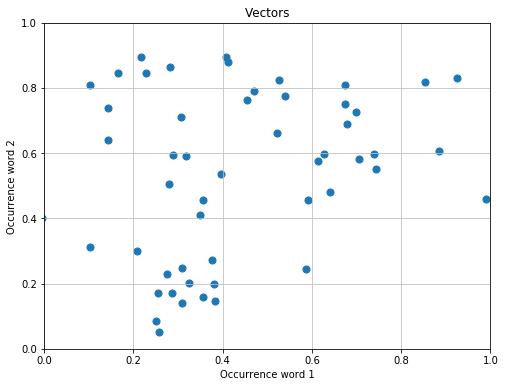

In [67]:
xw1 = norm(loc=0.3, scale=.15).rvs(20)
yw1 = norm(loc=0.3, scale=.15).rvs(20)

xw2 = norm(loc=0.7, scale=.15).rvs(20)
yw2 = norm(loc=0.7, scale=.15).rvs(20)

xw3 = norm(loc=0.2, scale=.15).rvs(20)
yw3 = norm(loc=0.8, scale=.15).rvs(20)

x = sp.append(sp.append(xw1, xw2), xw3)
y = sp.append(sp.append(yw1, yw2), yw3)

i = 1
plot_clustering(x, y, "Vectors")
pylab.savefig(os.path.join("..", "1400_03_0%i.png" % i))
pylab.show()
pylab.clf()

i += 1

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.90572262977


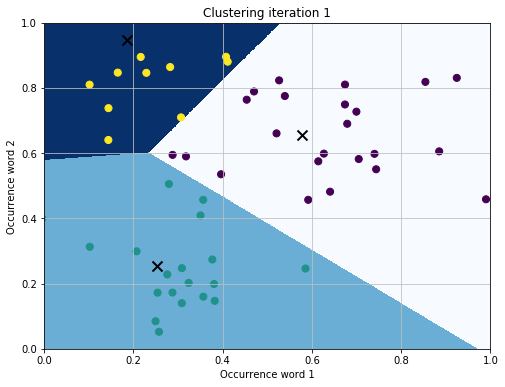

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.90572262977
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.39034740237


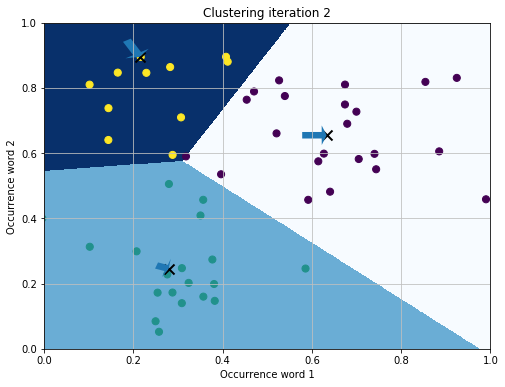

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2.90572262977
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.39034740237
start iteration
done sorting
end inner loop
Iteration 2, inertia 2.35256626213
start iteration
done sorting
end inner loop
Iteration 3, inertia 2.32148756511
start iteration
done sorting
end inner loop
Iteration 4, inertia 2.32148756511
center shift 0.000000e+00 within tolerance 7.136915e-06


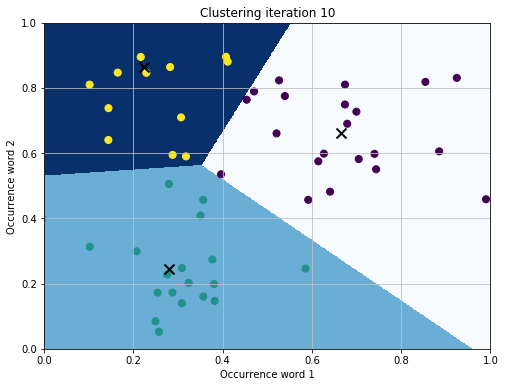

In [68]:
#################### 1 iteration ####################
'''
Here we're randomizing our starting vectors as starting points,
assigning labels to the rest,
and updating the cluster centers to be the new center point of all points in that cluster.
'''
mx, my = sp.meshgrid(sp.arange(0, 1, 0.001), sp.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
pylab.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=pylab.cm.Blues,
           aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            marker='x', linewidth=2, s=100, color='black')
pylab.savefig(os.path.join("..", "1400_03_0%i.png" % i))
pylab.show()
pylab.clf()

i += 1

#################### 2 iterations ####################
'''
Because the cluster centers are moved, 
we have to reassign the cluster labels and recalculate the cluster centers
Thus with iteration 2 we get the folllowing
'''
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=2,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
pylab.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=pylab.cm.Blues,
           aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            marker='x', linewidth=2, s=100, color='black')
# import pdb;pdb.set_trace()
pylab.gca().add_patch(
    pylab.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1))
pylab.gca().add_patch(
    pylab.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1))

pylab.savefig(os.path.join("..", "1400_03_0%i.png" % i))
pylab.show()
pylab.clf()

i += 1

#################### 3 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=10,
            random_state=seed)
km.fit(sp.array(list(zip(x, y))))

Z = km.predict(sp.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
pylab.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=pylab.cm.Blues,
           aspect='auto', origin='lower')

pylab.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            marker='x', linewidth=2, s=100, color='black')
pylab.savefig(os.path.join("..", "1400_03_0%i.png" % i))
pylab.show()
pylab.clf()

i += 1

After the clustering has settled, we just need to note down the cluster centers and their identity. 

When each new document comes in, we have to vectorize and compare it with all the cluster centers. 

The cluster center with the smallest distance to our new post vector belongs to the cluster we will assign to the new post.

### Using Real Test Data

In [76]:
import sklearn.datasets
MLCOMP_DIR = r"../data/"
data = sklearn.datasets.load_mlcomp("20news-18828", mlcomp_root=MLCOMP_DIR)
print(data.filenames)
print(len(data.filenames))
print data.target_names

[ '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/comp.graphics/1190-38614'
 '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/comp.graphics/1383-38616'
 '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/alt.atheism/487-53344'
 ...,
 '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/rec.sport.hockey/10215-54303'
 '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/sci.crypt/10799-15660'
 '/Users/bill_mac/github_repos/Python_Projects/data-analysis/clustering - finding related texts/data/379/raw/comp.os.ms-windows.misc/2732-10871']
18828
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.mot

In [77]:
train_data = sklearn.datasets.load_mlcomp("20news-18828", "train", mlcomp_root=MLCOMP_DIR)
print(len(train_data.filenames))
test_data = sklearn.datasets.load_mlcomp("20news-18828", "test", mlcomp_root=MLCOMP_DIR)
print(len(test_data.filenames))

13180
5648


In [78]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ma c.hardware', 'comp.windows.x', 'sci.space']
train_data = sklearn.datasets.load_mlcomp("20news-18828", "train", mlcomp_root=MLCOMP_DIR, categories=groups)
print(len(train_data.filenames))

3414


### Clustering posts

You must have already noticed one thing – real data is noisy. 

The newsgroup dataset is no exception. It even contains invalid characters that will result in `UnicodeDecodeError`.  It's super annoying.

We have to tell the vectorizer to ignore them:

In [85]:
dataset = train_data
labels = dataset.target
num_clusters = 50  # sp.unique(labels).shape[0]

import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))


In [92]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                    # max_features=1000,
                                    stop_words='english', decode_error ='ignore',
                                    )
vectorized = vectorizer.fit_transform(dataset.data)
num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))



#samples: 3414, #features: 4331


In [93]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1,
            verbose=1)

clustered = km.fit(vectorized)


Initialization complete
Iteration  0, inertia 5469.651
Iteration  1, inertia 3059.438
Iteration  2, inertia 3027.446
Iteration  3, inertia 3016.790
Iteration  4, inertia 3011.225
Iteration  5, inertia 3008.811
Iteration  6, inertia 3007.565
Iteration  7, inertia 3006.344
Iteration  8, inertia 3005.867
Iteration  9, inertia 3005.680
Iteration 10, inertia 3005.586
Iteration 11, inertia 3005.441
Iteration 12, inertia 3005.385
Converged at iteration 12: center shift 0.000000e+00 within tolerance 2.251613e-08


In [96]:
print km.labels_
print km.labels_.shape

[26 18 14 ..., 28 42 11]
(3414,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119a3dd90>]], dtype=object)

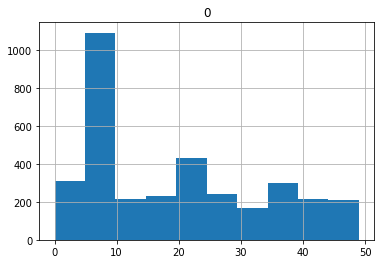

In [101]:
import pandas as pd
pd.DataFrame(km.labels_).hist()

In [94]:
from sklearn import metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand Index: %0.3f" %
      metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted Mutual Information: %0.3f" %
      metrics.adjusted_mutual_info_score(labels, km.labels_))
print(("Silhouette Coefficient: %0.3f" %
       metrics.silhouette_score(vectorized, labels, sample_size=1000)))

Homogeneity: 0.473
Completeness: 0.226
V-measure: 0.306
Adjusted Rand Index: 0.089
Adjusted Mutual Information: 0.219
Silhouette Coefficient: 0.007


### Let's go for it and see how it works on new data

In [104]:
new_post = \
    """Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
"""

As we know, we will first have to vectorize this post before we predict its label as follows:

In [105]:
new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]


Now that we have the clustering, we do not need to compare new_post_vec to all post vectors. 

Instead, we can focus only on the posts of the same cluster. Let us fetch their indices in the original dataset:

In [106]:
similar_indices = (km.labels_ == new_post_label).nonzero()[0]

The comparison in the bracket results in a Boolean array, and nonzero converts that array into a smaller array containing the indices of the True elements.

Using similar_indices, we then simply have to build a list of posts together with their similarity scores as follows:

In [107]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, dataset.data[i]))

similar = sorted(similar)

In [108]:
print len(similar)

110


We found 110 posts in the cluster of our post. To give the user a quick idea of what kind of similar posts are available, we can now present the most similar post (show_at_1), the least similar one (show_at_3), and an in-between post (show_at_2), all of which are from the same cluster as follows:

In [111]:
# import pdb
# pdb.set_trace()

show_at_1 = similar[0]
show_at_2 = similar[len(similar) / 2]
show_at_3 = similar[-1]

print(show_at_1)
print
print
print(show_at_2)
print
print
print(show_at_3)

(1.0180360777083872, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel                                                    |\n| Internet: GERTHD@MVS.SAS.COM                                      |\